# 基于物理公式进行特征选择的关于e_total模型 

[TOC]

## 进行特征清洗 

- **去除掉相关性较强的俩个特征中的一个** ----- Pearson相关系数

In [1]:
# 导库
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression

In [2]:
# 一些参数
TEST_SIZE = 0.30
RANDOM_STATE = 42
N_SPLITS = 10
# 决策树的深度
BEST_DEPTH = None

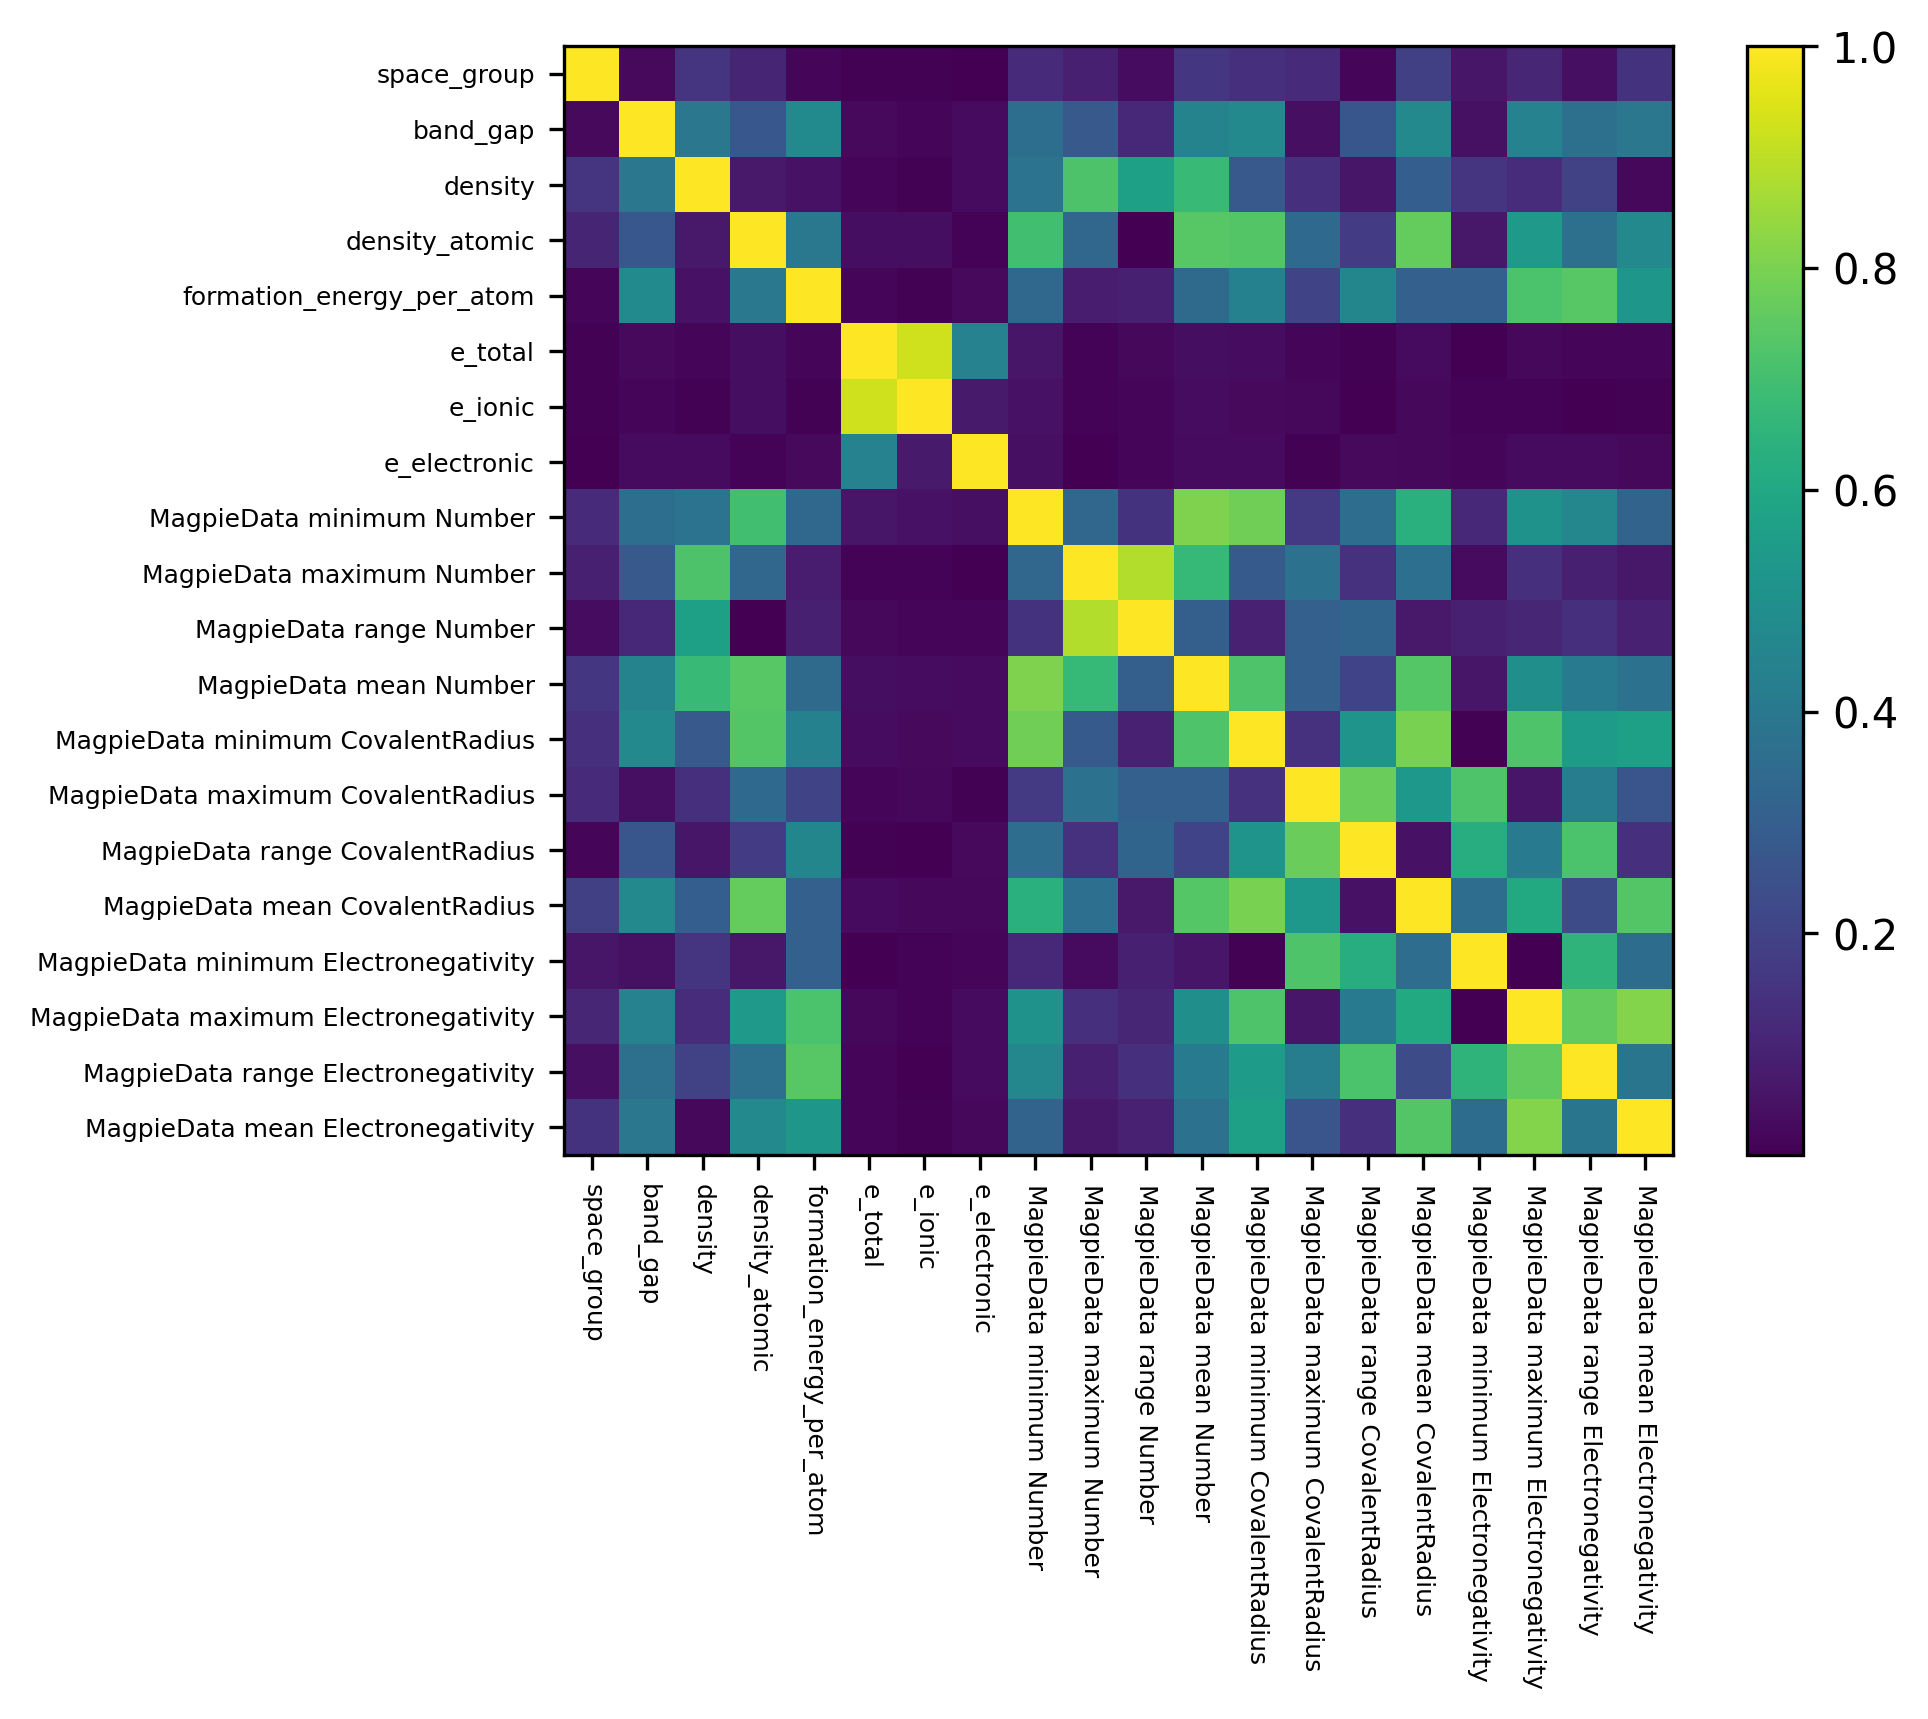

In [3]:
# 导入数据
data_featurized = pd.read_csv('../data/data_training.csv')

corr_matrix = data_featurized.corr(numeric_only=True).abs()   # we take the absolute value
fig, ax = plt.subplots(dpi=300)
h = ax.imshow(corr_matrix)
# 设置坐标名称
ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_yticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, fontsize=6, rotation=-90)
ax.set_yticklabels(corr_matrix.columns, fontsize=6)
plt.colorbar(h)
plt.show()

### （一）. 使用线性回归模型训练

#### 1. 进行特征缩放，归一化

In [4]:
data_featurized.drop(columns=['material_id', 'composition', 'crystal_system'], inplace=True)
data_featurized.head()

,space_group,band_gap,density,density_atomic,formation_energy_per_atom,e_total,e_ionic,e_electronic,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData minimum CovalentRadius,MagpieData maximum CovalentRadius,MagpieData range CovalentRadius,MagpieData mean CovalentRadius,MagpieData minimum Electronegativity,MagpieData maximum Electronegativity,MagpieData range Electronegativity,MagpieData mean Electronegativity
0,11,0.7792,5.022717,22.595815,-1.124079,17.048334,7.118969,9.929365,16.0,56.0,40.0,30.285714,105.0,215.0,110.0,130.428571,0.89,2.58,1.69,2.230000
1,19,2.8980,3.764366,15.869706,-3.099174,17.572010,13.469477,4.102533,8.0,41.0,33.0,16.500000,57.0,164.0,107.0,88.250000,1.60,3.98,2.38,3.115000
2,1,1.7212,3.094976,28.031499,-0.766100,18.488667,12.443616,6.045051,16.0,38.0,22.0,24.000000,105.0,195.0,90.0,121.857143,0.95,2.58,1.63,2.232857
3,12,2.0944,2.901260,12.923684,-1.948264,9.596025,6.499905,3.096120,8.0,26.0,18.0,11.083333,66.0,166.0,100.0,86.333333,0.93,3.44,2.51,2.953333
4,62,7.4812,1.860992,9.355010,-1.970766,6.216546,4.350314,1.866232,1.0,9.0,8.0,5.200000,31.0,84.0,53.0,50.700000,2.04,3.98,1.94,2.980000


In [5]:
X = data_featurized.drop(columns=['e_total', 'e_ionic', 'e_electronic'])

In [6]:
y_e_total = data_featurized['e_total']
y_e_ionic = data_featurized['e_ionic']
y_eletronic = data_featurized['e_electronic']

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

2. 训练集测试集划分

In [8]:
# 训练集测试集划分
X_train, X_test, y_train, y_test = train_test_split(X, y_e_total, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## 进行模型训练

In [9]:
def model_cross_train(model, X, y):
    '''在X上训练模型model，返回交叉验证的结果：
        1. scores（neg_root_mean_squared_error）
        2. y_hat'''
    # 进行k折交叉验证
    # cross_val_predict()函数不会改变原始的模型。这个函数的主要目的是使用交叉验证来为每个输入数据点生成预测值。
    kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
    y_hat = cross_val_predict(model, X, y, cv=kfold)
    return scores, y_hat

In [10]:
# 确定好全部超参数后，使用最优的超参数在整个训练集上训练模型
def model_final_train(model, X_train, y_train):
    '''在整个训练集上训练模型model，返回训练好的模型'''
    model.fit(X_train, y_train)
    return model

def model_test(model, X_test, y_test):
    '''在测试集上测试模型model，返回测试结果：
        1. mean_squared_error
        2. mean_absolute_error
        3. y_pred'''
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return mse, mae, ypred

#### 1. LinearRegression模型 

MSE: -359.15223123071064


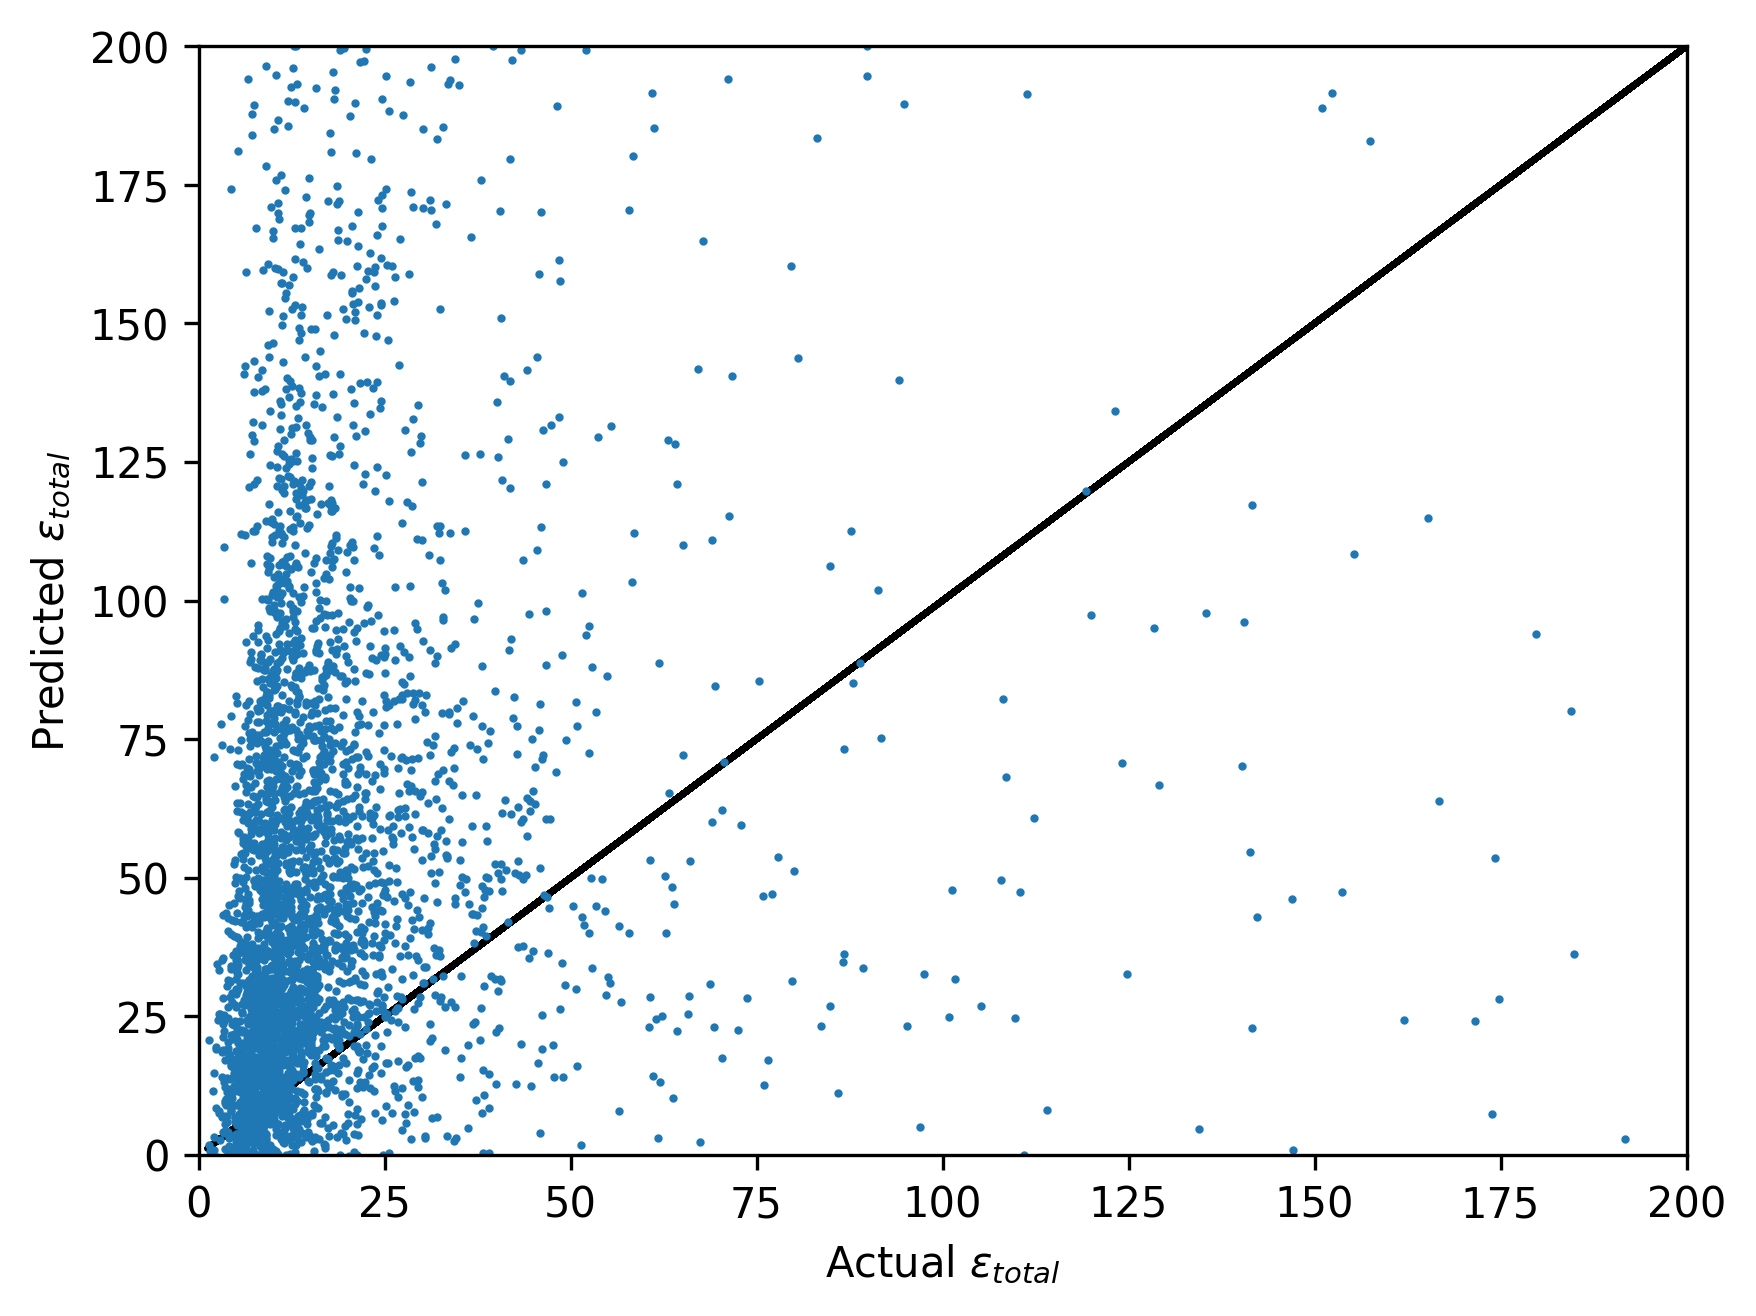

In [11]:
# 这个模型使用解析解，故不包含学习率的设置
lr = LinearRegression()
scores, y_hat = model_cross_train(lr, X_train, y_train)

def plot_cross_val_scores(scores, y_hat):
    '''绘制交叉验证的结果'''
    print(f'MSE: {scores.mean()}')

    # 绘制parity plot
    fig, ax = plt.subplots(dpi=300)
    ax.scatter(y_train, y_hat, s=1)
    ax.plot(y_train, y_train, c='k', zorder=-5)
    ax.set_xlabel('Actual $\epsilon_{total}$')
    ax.set_ylabel('Predicted $\epsilon_{total}$')
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.set_xlim(0, 200)
    ax.set_ylim(0, 200)
    plt.show()
    return fig

fig = plot_cross_val_scores(scores, y_hat)


#### 2. 决策树模型


MSE: -692.7323692304813


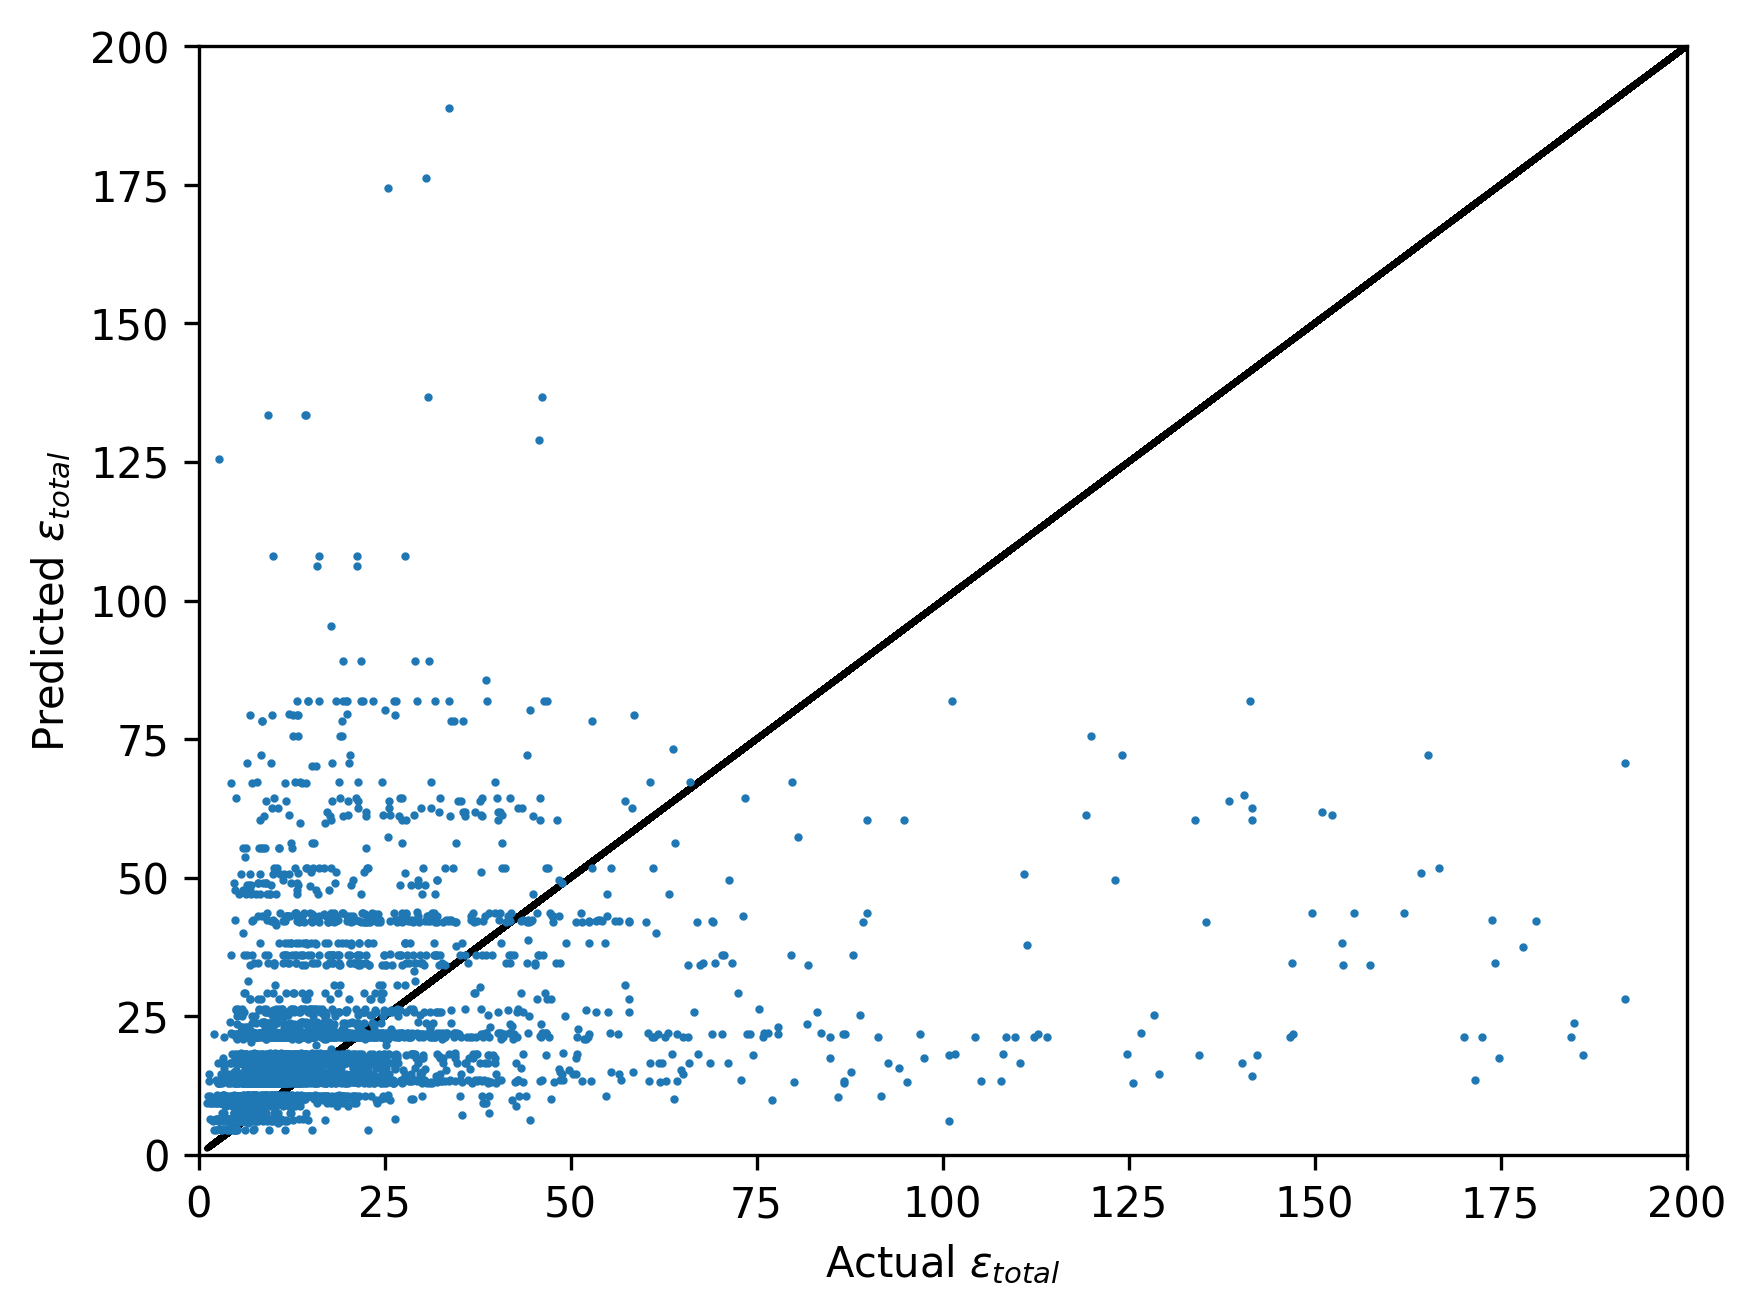

MSE: -447.8190522904115


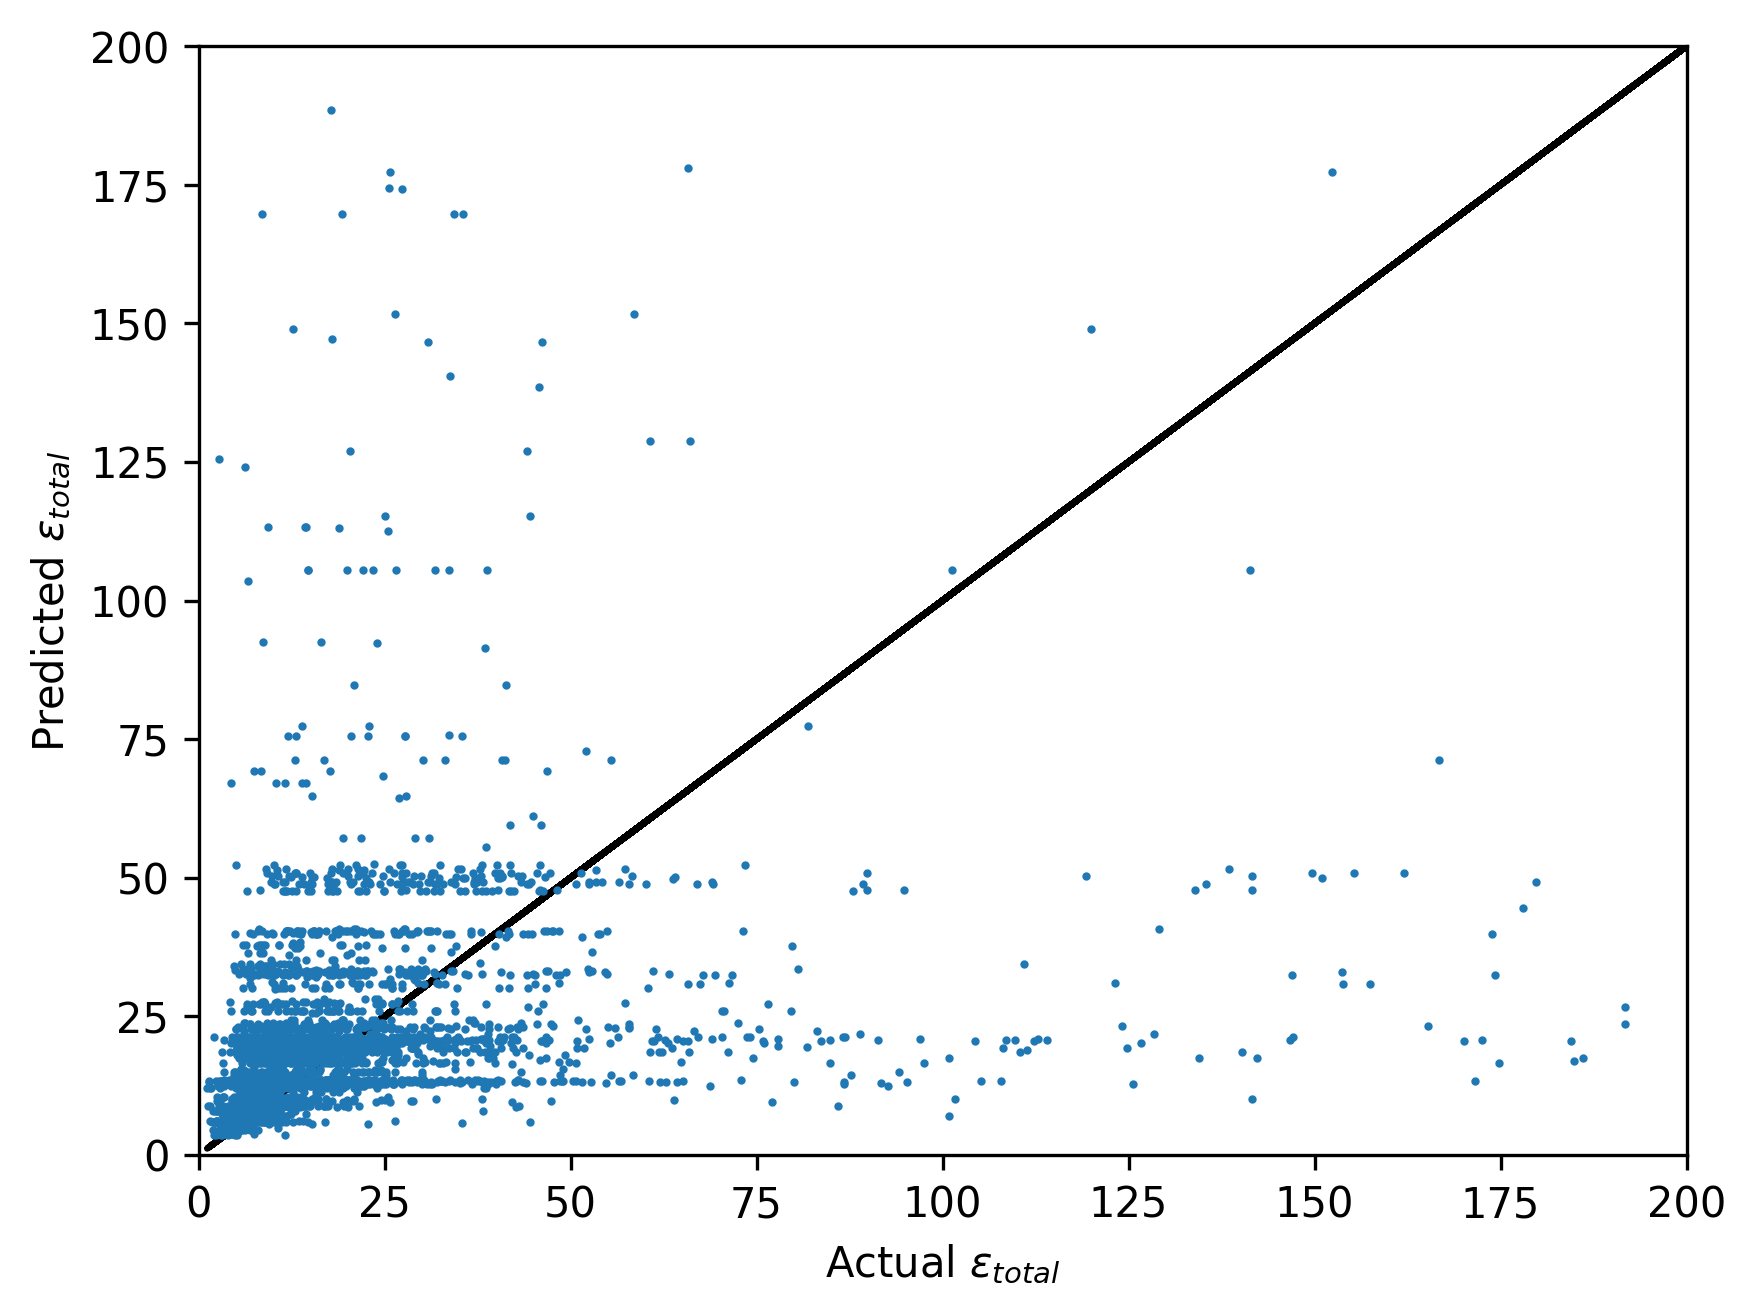

Best depth: 7


In [12]:
from sklearn.tree import DecisionTreeRegressor, plot_tree       # ML model

# 确定超参数MAX_DEPTH后，使用最优的超参数在整个训练集上训练模型
max_scores=-1e5
BEST_DEPTH=0
for depth in range(6, 15):
    dt = DecisionTreeRegressor(max_depth=depth,random_state=RANDOM_STATE)      # decision tree constructor
    scores, y_hat = model_cross_train(dt, X_train, y_train)                              
    if scores.mean() > max_scores:
        max_scores = scores.mean()
        BEST_DEPTH = depth
        plot_cross_val_scores(scores, y_hat)

print(f'Best depth: {BEST_DEPTH}')

#### 3. 随机森林算法

MSE: -743.8159127526613


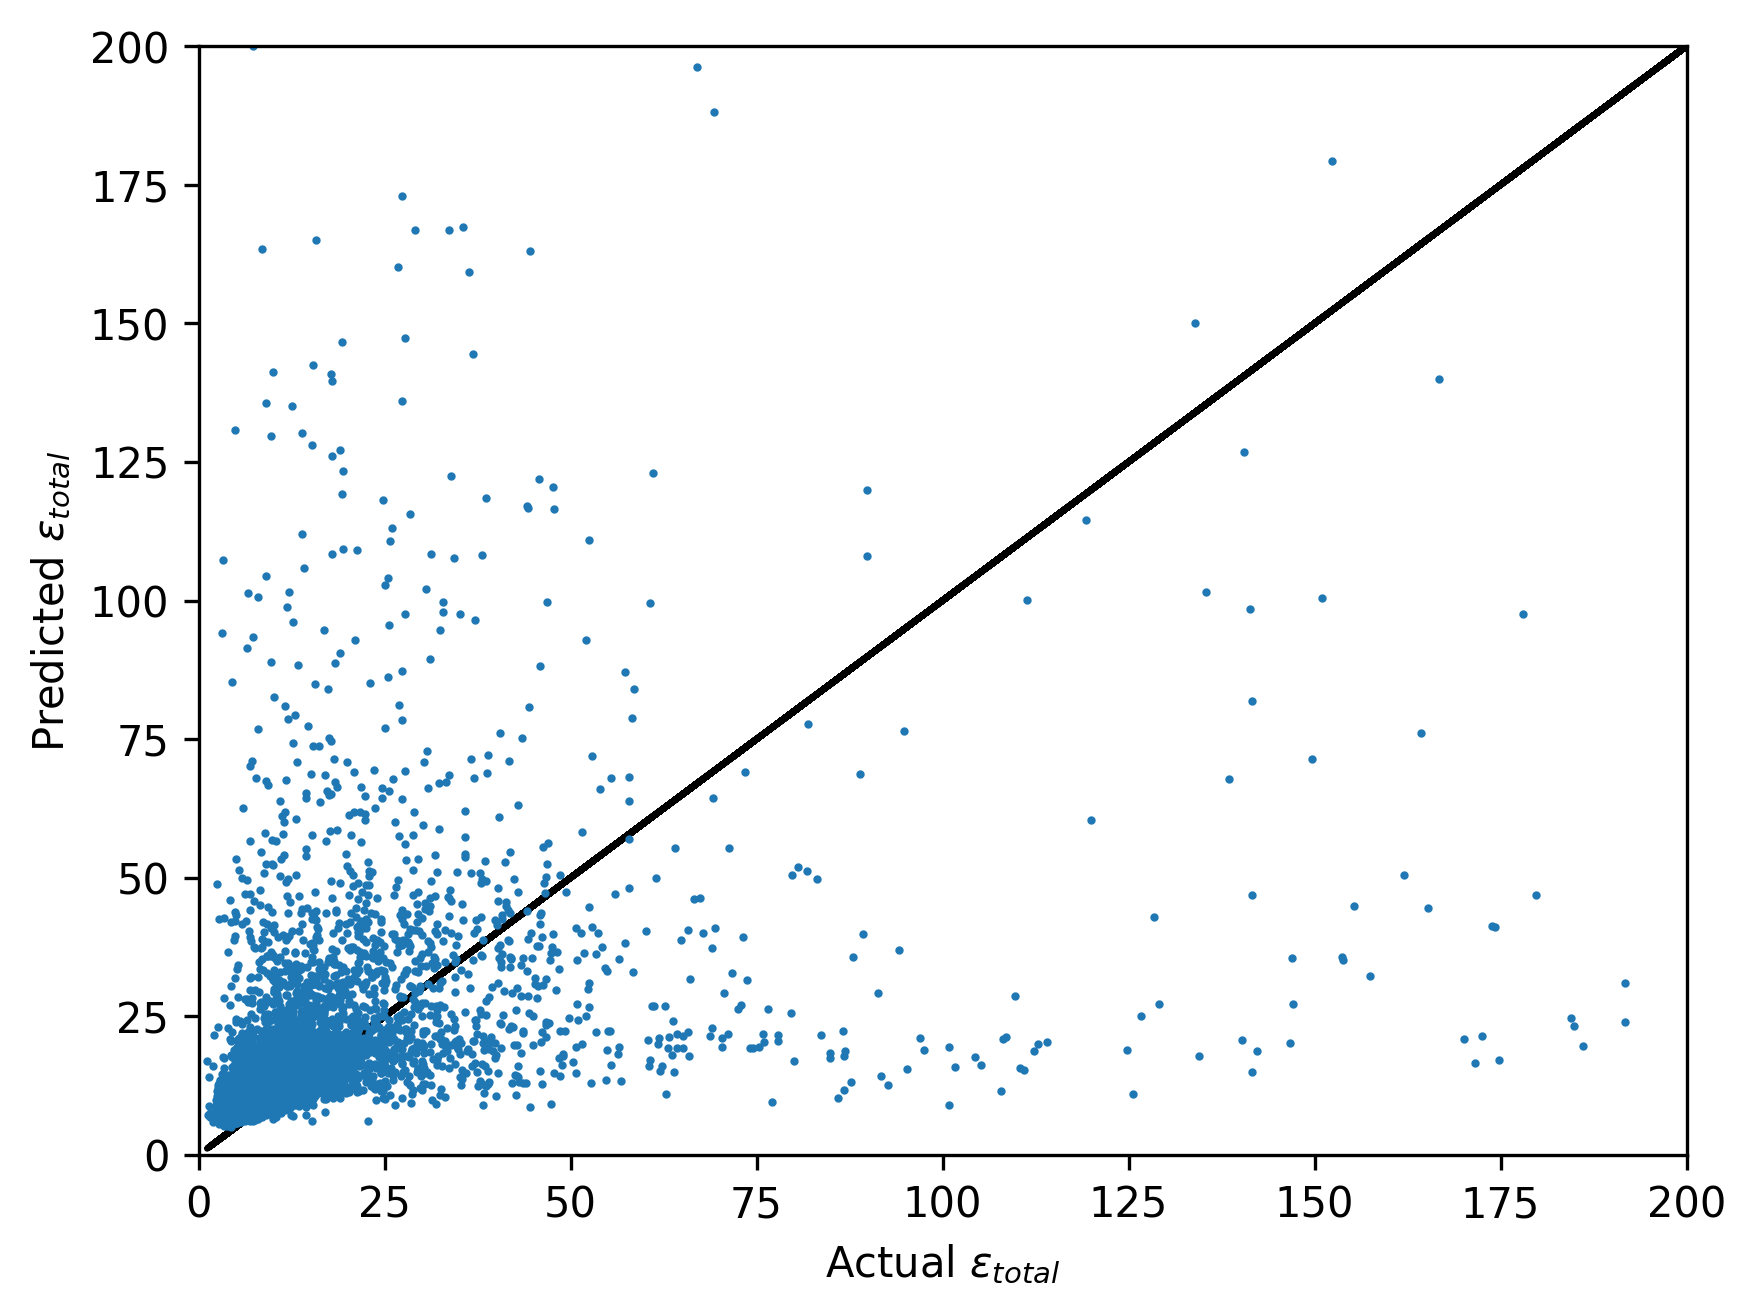

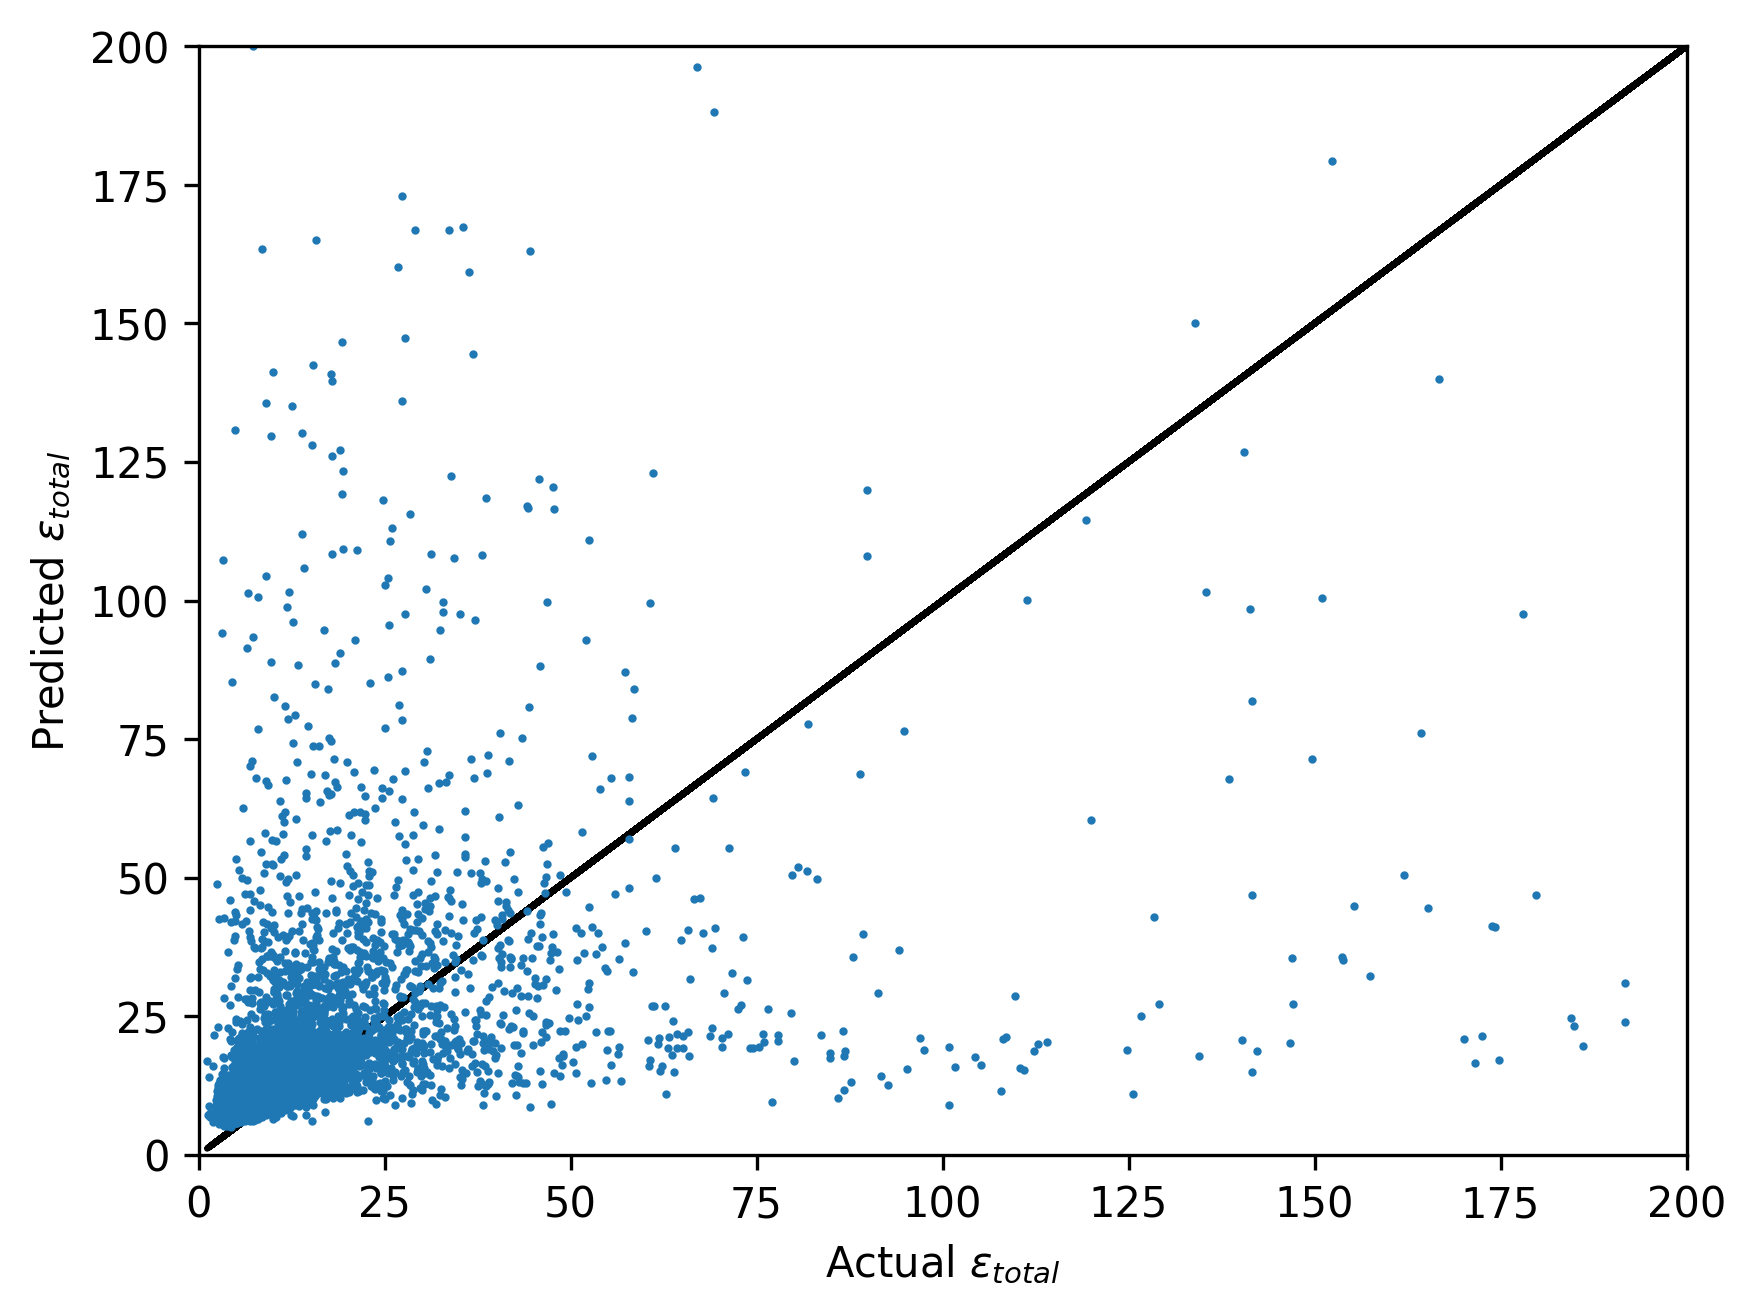

In [13]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, max_depth=BEST_DEPTH, random_state=RANDOM_STATE)
scores, y_hat = model_cross_train(rf, X_train, y_train)
plot_cross_val_scores(scores, y_hat)

#### 4. 使用神经网络

In [47]:
# 加载数据
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data.to_numpy()
        self.targets = targets.to_numpy().reshape(-1, 1)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # 根据索引获取数据和目标，并将它们转换为张量
        x = torch.tensor(self.data[index], dtype=torch.float32)
        y = torch.tensor(self.targets[index], dtype=torch.float32)
        return x, y
    
# 创建自定义数据集实例
dataset = CustomDataset(X_train, y_train)   # 注意X_train,y_train都为pandas.DataFrame
# 创建数据加载器
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [48]:
X_train.shape

(5093, 17)

In [53]:
# 搭建神经网络
import torch.nn as nn
# 导入optim
import torch.optim as optim

class NN_model(nn.Module):
    def __init__(self):
        super(NN_model, self).__init__()
        
        # 使用Sequential定义神经网络的结构
        self.layers = nn.Sequential(
            nn.Linear(17, 9),
            nn.ReLU(),
            nn.Linear(9, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )
        
    def forward(self, x):
        # 前向传播
        return self.layers(x)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)
# 定义超参数
input_size = 17
output_size = 1
learning_rate = 0.002
num_epochs = 1000

# 初始化模型、损失函数和优化器
model = NN_model()
# 使用均方误差作为损失函数
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.to(device)
criterion.to(device)
# 训练模型
model.train()
for epoch in range(num_epochs):
    # Forward pass
    epoch_loss = 0
    for i, (features, targets) in enumerate(data_loader):
        features = features.to(device)
        targets = targets.to(device)
        outputs = model(features)
        loss = criterion(outputs, targets)
        epoch_loss += loss.item()
        # Backward and optimize
        optimizer.zero_grad()    # 梯度重置
        loss.backward() # 向后传播计算梯度
        optimizer.step() # 通过梯度更新参数

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, MSE: {epoch_loss/len(dataset):.4f}')

cuda
Epoch [100/1000], Loss: 61031181.3977, MSE: 11983.3460
Epoch [200/1000], Loss: 59379367.7946, MSE: 11659.0159
Epoch [300/1000], Loss: 56830277.7713, MSE: 11158.5073
Epoch [400/1000], Loss: 50561411.6300, MSE: 9927.6284
Epoch [500/1000], Loss: 45370342.8445, MSE: 8908.3728
Epoch [600/1000], Loss: 37826361.5218, MSE: 7427.1277
Epoch [700/1000], Loss: 25705532.5477, MSE: 5047.2281
Epoch [800/1000], Loss: 18516782.7835, MSE: 3635.7319
Epoch [900/1000], Loss: 13218591.0338, MSE: 2595.4430
Epoch [1000/1000], Loss: 10624990.9867, MSE: 2086.1950


In [57]:
X_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_tensor = X_tensor.to(device)
y_hat = model(X_tensor)

In [58]:
y_hat[0:5]

tensor([[50.5029],
        [12.9357],
        [12.9357],
        [12.9357],
        [17.9290]], device='cuda:0', grad_fn=<SliceBackward0>)

In [62]:
display(X_tensor[:5])
display(X_train[:5])

tensor([[164.0000,   3.8971,   3.8104,  42.6906,  -1.9282,  20.0000,  53.0000,
          33.0000,  42.0000, 139.0000, 176.0000,  37.0000, 151.3333,   1.0000,
           2.6600,   1.6600,   2.1067],
        [122.0000,   2.0955,   4.9471,  23.8650,  -2.3855,  16.0000,  59.0000,
          43.0000,  31.4286, 105.0000, 203.0000,  98.0000, 145.8571,   0.9500,
           2.5800,   1.6300,   1.9329],
        [225.0000,   3.0173,   6.8928,  14.3716,  -3.5906,   8.0000,  73.0000,
          65.0000,  25.4000,  66.0000, 215.0000, 149.0000, 116.6000,   0.8900,
           3.4400,   2.5500,   2.5280],
        [225.0000,   1.4541,   3.8802,  32.6068,  -1.7441,  17.0000,  82.0000,
          65.0000,  32.6667, 102.0000, 244.0000, 142.0000, 138.4444,   0.7900,
           3.1600,   2.3700,   2.5411],
        [ 15.0000,   2.5261,   4.4263,  10.8753,  -2.3716,   8.0000,  32.0000,
          24.0000,  13.6000,  66.0000, 141.0000,  75.0000,  91.8000,   1.3100,
           3.4400,   2.1300,   2.7280]], device='c

,space_group,band_gap,density,density_atomic,formation_energy_per_atom,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData minimum CovalentRadius,MagpieData maximum CovalentRadius,MagpieData range CovalentRadius,MagpieData mean CovalentRadius,MagpieData minimum Electronegativity,MagpieData maximum Electronegativity,MagpieData range Electronegativity,MagpieData mean Electronegativity
2628,164,3.8971,3.810445,42.690617,-1.928175,20.0,53.0,33.0,42.000000,139.0,176.0,37.0,151.333333,1.00,2.66,1.66,2.106667
3014,122,2.0955,4.947128,23.865003,-2.385492,16.0,59.0,43.0,31.428571,105.0,203.0,98.0,145.857143,0.95,2.58,1.63,1.932857
2154,225,3.0173,6.892776,14.371590,-3.590597,8.0,73.0,65.0,25.400000,66.0,215.0,149.0,116.600000,0.89,3.44,2.55,2.528000
1344,225,1.4541,3.880169,32.606816,-1.744127,17.0,82.0,65.0,32.666667,102.0,244.0,142.0,138.444444,0.79,3.16,2.37,2.541111
7036,15,2.5261,4.426263,10.875263,-2.371639,8.0,32.0,24.0,13.600000,66.0,141.0,75.0,91.800000,1.31,3.44,2.13,2.728000


In [63]:
# 继续训练
# 训练模型
model.train()
for epoch in range(num_epochs*2):
    # Forward pass
    epoch_loss = 0
    for i, (features, targets) in enumerate(data_loader):
        features = features.to(device)
        targets = targets.to(device)
        outputs = model(features)
        loss = criterion(outputs, targets)
        epoch_loss += loss.item()
        # Backward and optimize
        optimizer.zero_grad()    # 梯度重置
        loss.backward() # 向后传播计算梯度
        optimizer.step() # 通过梯度更新参数

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, MSE: {epoch_loss/len(dataset):.4f}')

Epoch [100/1000], Loss: 9806862.6316, MSE: 1925.5572
Epoch [200/1000], Loss: 9259110.0090, MSE: 1818.0071
Epoch [300/1000], Loss: 9438925.2977, MSE: 1853.3134
Epoch [400/1000], Loss: 9071454.6060, MSE: 1781.1613
Epoch [500/1000], Loss: 9250957.2416, MSE: 1816.4063
Epoch [600/1000], Loss: 9162271.5731, MSE: 1798.9930
Epoch [700/1000], Loss: 9018491.0991, MSE: 1770.7620
Epoch [800/1000], Loss: 8767155.2041, MSE: 1721.4128
Epoch [900/1000], Loss: 8696095.5231, MSE: 1707.4603
Epoch [1000/1000], Loss: 8744150.1546, MSE: 1716.8958
Epoch [1100/1000], Loss: 8416580.9385, MSE: 1652.5782
Epoch [1200/1000], Loss: 10361119.0119, MSE: 2034.3843
Epoch [1300/1000], Loss: 8220164.6856, MSE: 1614.0123
Epoch [1400/1000], Loss: 7945420.9680, MSE: 1560.0669
Epoch [1500/1000], Loss: 12622858.5890, MSE: 2478.4721
Epoch [1600/1000], Loss: 18650052.6548, MSE: 3661.8992
Epoch [1700/1000], Loss: 11188387.1299, MSE: 2196.8166
Epoch [1800/1000], Loss: 7450658.0503, MSE: 1462.9213
Epoch [1900/1000], Loss: 6806828.

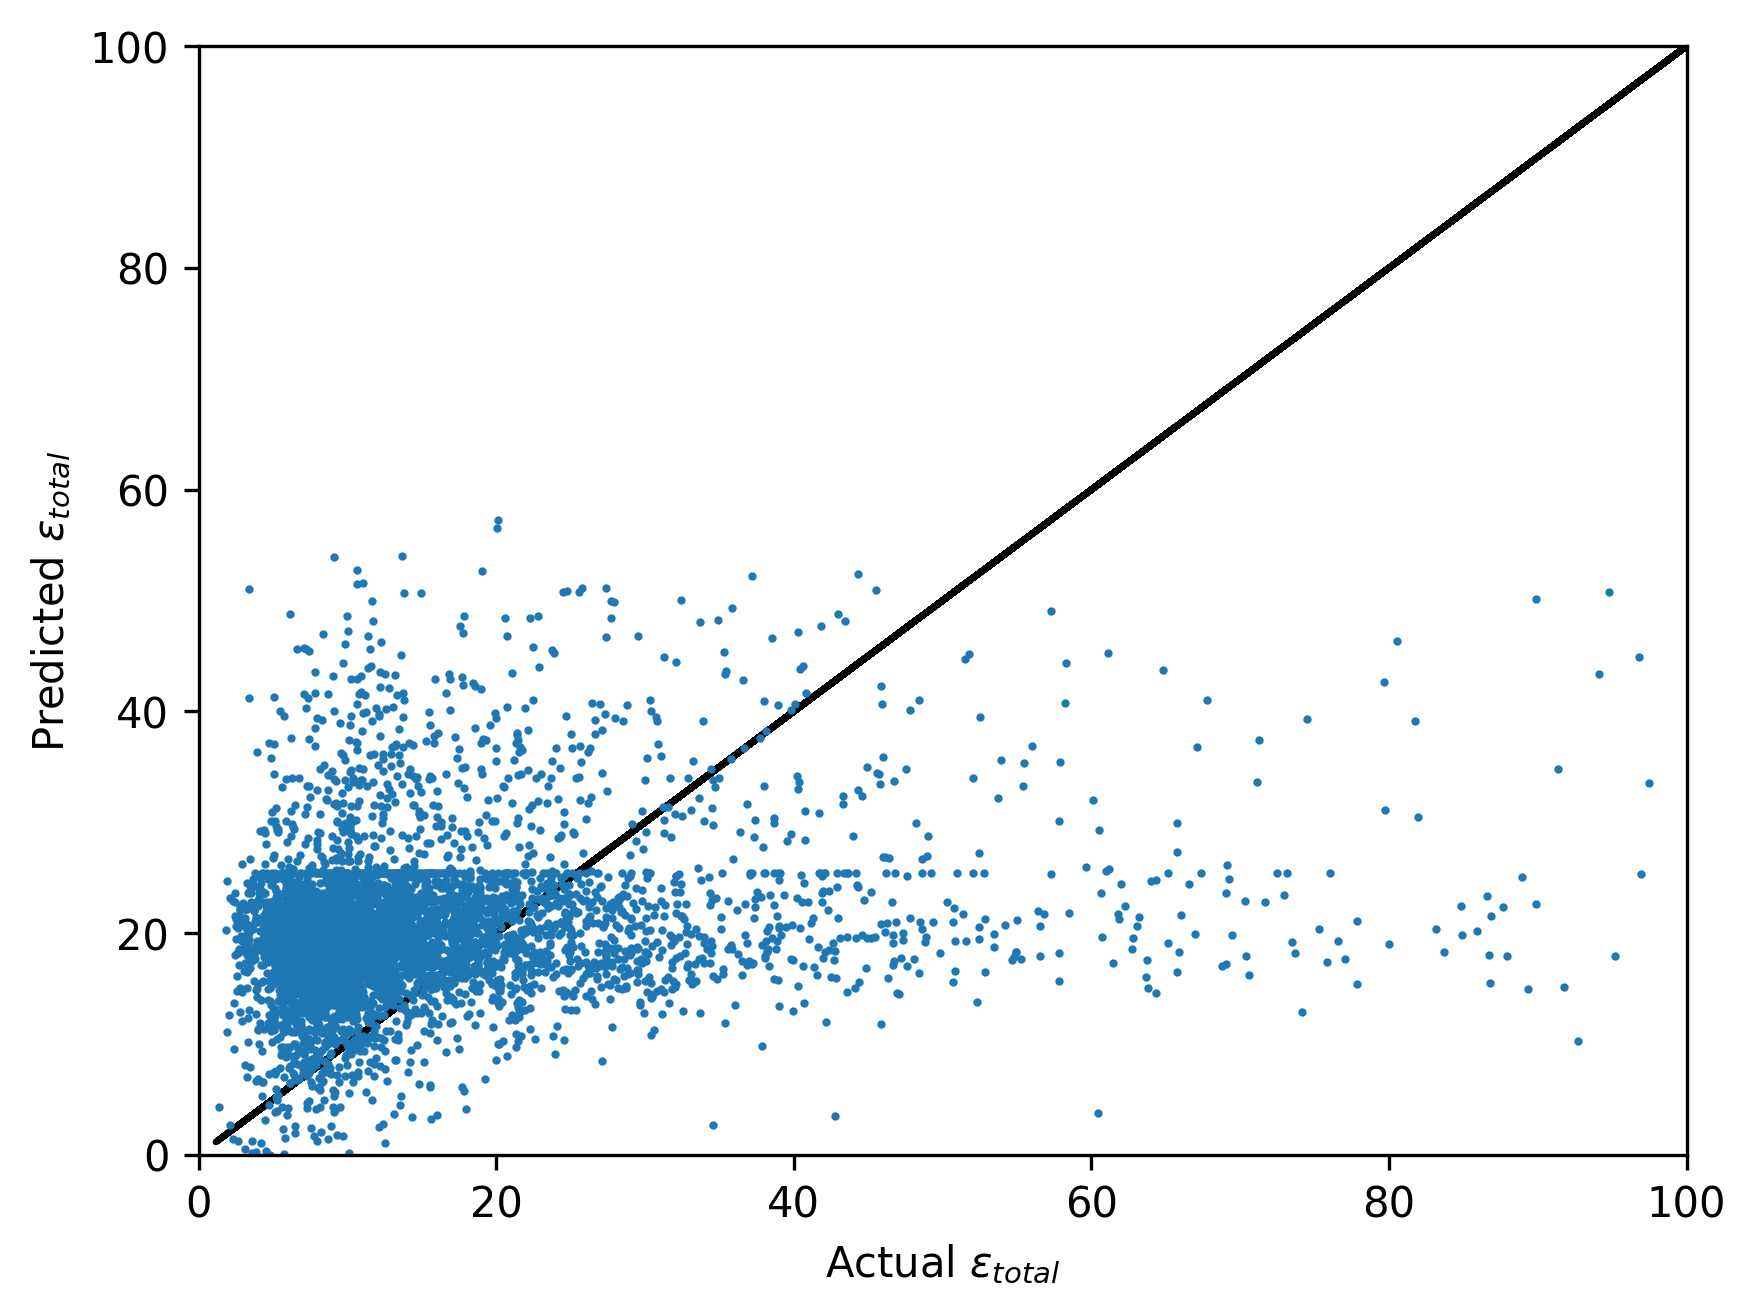

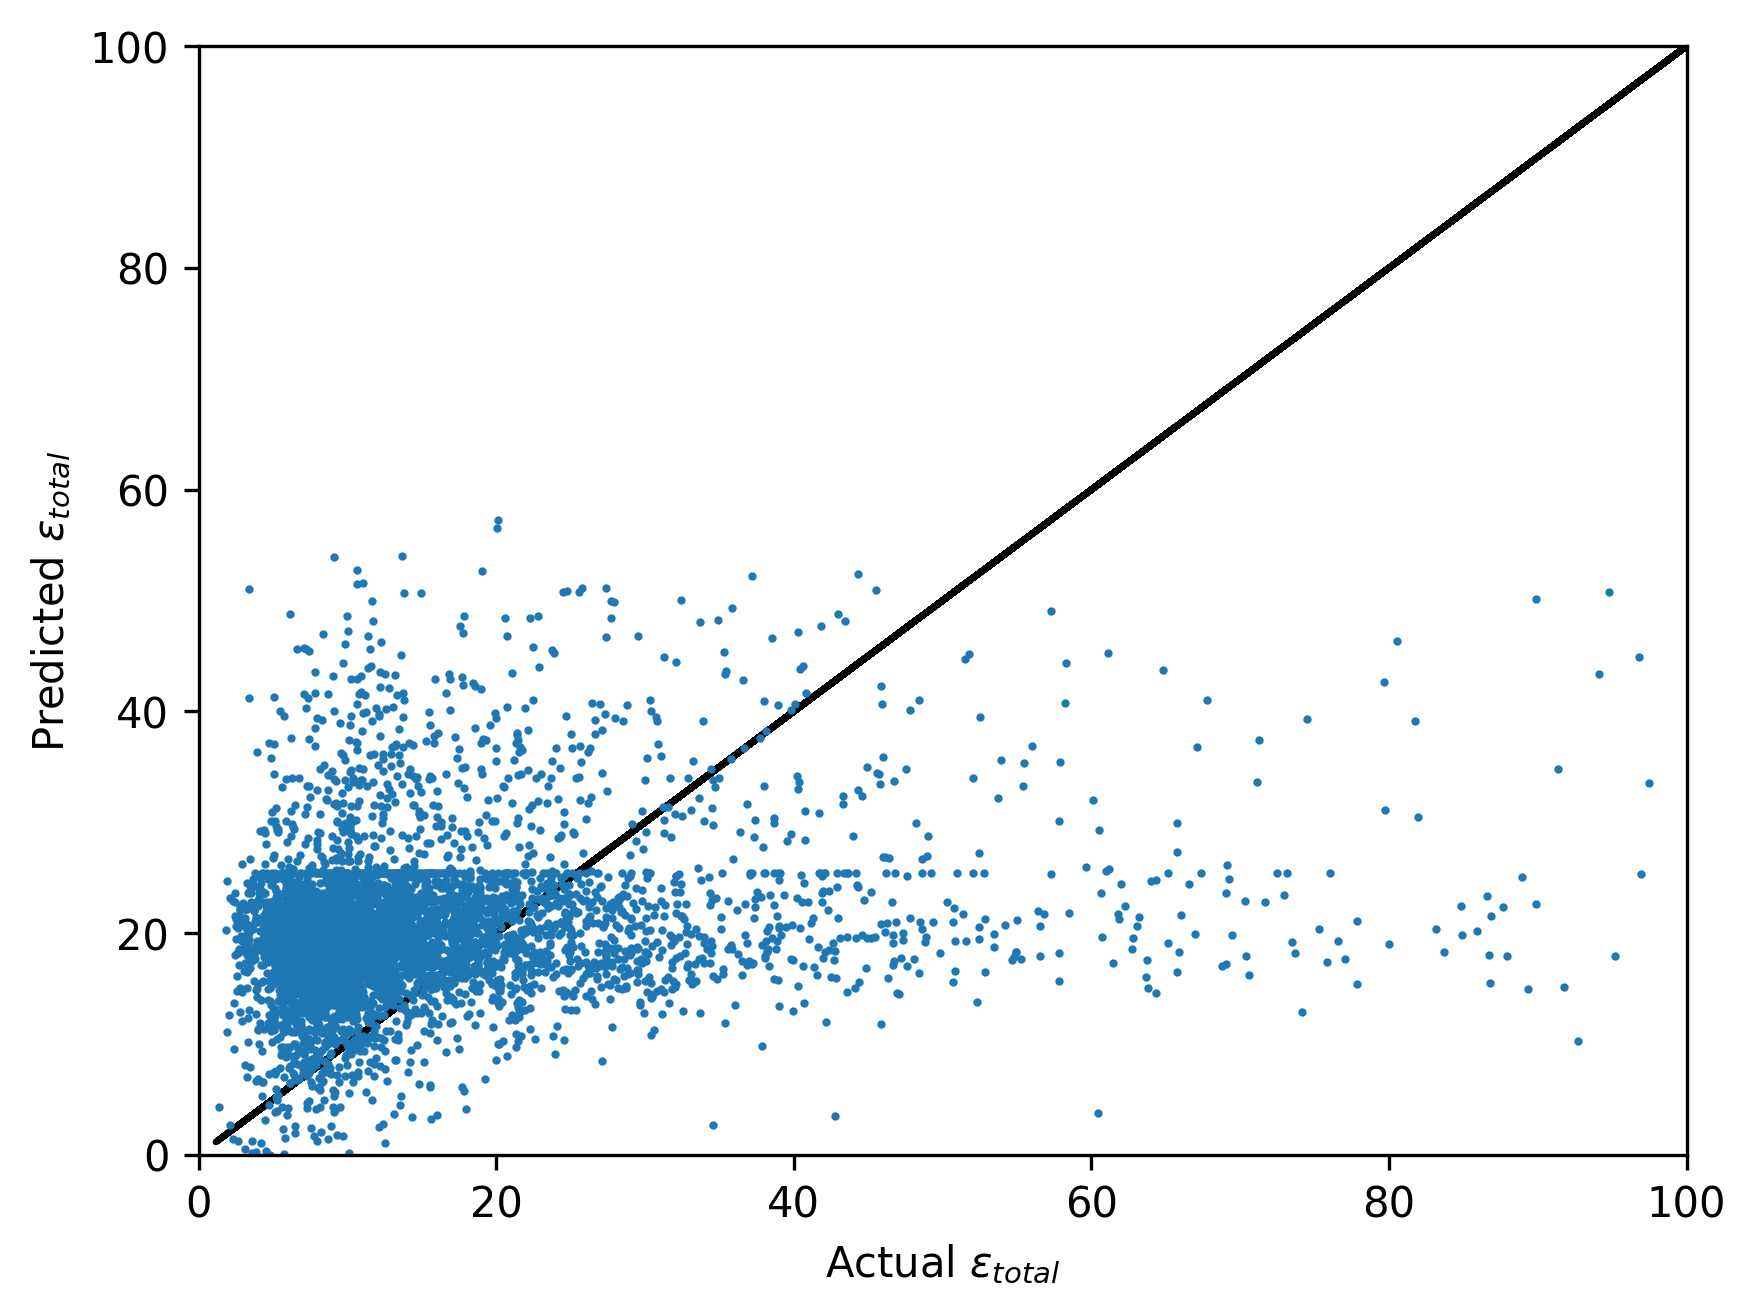

In [74]:
y_hat = model(X_tensor)
def parity_plot(y_hat):
    # 绘制parity plot
    fig, ax = plt.subplots(dpi=300)
    ax.scatter(y_train, y_hat, s=1)
    ax.plot(y_train, y_train, c='k', zorder=-5)
    ax.set_xlabel('Actual $\epsilon_{total}$')
    ax.set_ylabel('Predicted $\epsilon_{total}$')
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    plt.show()
    
parity_plot(y_hat.detach().cpu().numpy())

In [76]:
# 保存模型
torch.save(model.state_dict(), 'NN_model.pth')